# <div class="alert alert-block alert-success">About this notebook</div>

In this notebook, I tried to see similarity of foods.

I focus on ingredients of food. This is because if we use same ingredient, the results should be naturally similar. Of cource, even if the ingredients are the same, different processing methods could result in a completely different dish, but let's turn a blind eye to that in this case.

But by putting this simple hypothesis, I found interesting result, so I'll share that.

<u>update information</u>

version1: first release

version2: fixed calculation method of ingredients word.

## <div class="alert alert-block alert-info">Preperation</div>

## Load liblraries

In [1]:
import collections
import json
import os

import folium
import matplotlib.pyplot as plt
import nltk
import numpy as np
import re
import pandas as pd
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
import umap
from wordcloud import WordCloud

In [2]:
for dirname, _, filenames in os.walk('input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

input/indian_food.csv


## Data overviewing

Let's load dataset. There are one csv data.

In [3]:
!ls ../input/indian-food-101

ls: ../input/indian-food-101: No such file or directory


In [4]:
df = pd.read_csv("input/indian_food.csv")

In [5]:
df.head()

name                                        ingredients  \
0      Balu shahi                    Maida flour, yogurt, oil, sugar   
1          Boondi                            Gram flour, ghee, sugar   
2  Gajar ka halwa       Carrots, milk, sugar, ghee, cashews, raisins   
3          Ghevar  Flour, ghee, kewra, milk, clarified butter, su...   
4     Gulab jamun  Milk powder, plain flour, baking powder, ghee,...   

         diet  prep_time  cook_time flavor_profile   course        state  \
0  vegetarian         45         25          sweet  dessert  West Bengal   
1  vegetarian         80         30          sweet  dessert    Rajasthan   
2  vegetarian         15         60          sweet  dessert       Punjab   
3  vegetarian         15         30          sweet  dessert    Rajasthan   
4  vegetarian         15         40          sweet  dessert  West Bengal   

  region  
0   East  
1   West  
2  North  
3   West  
4   East

In [6]:
df.shape

(255, 9)

This data has 9 columns and 255 records.

Let's see data type and wheather there are null or not.

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 255 entries, 0 to 254
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   name            255 non-null    object
 1   ingredients     255 non-null    object
 2   diet            255 non-null    object
 3   prep_time       255 non-null    int64 
 4   cook_time       255 non-null    int64 
 5   flavor_profile  255 non-null    object
 6   course          255 non-null    object
 7   state           255 non-null    object
 8   region          254 non-null    object
dtypes: int64(2), object(7)
memory usage: 18.1+ KB


There are no null. prep_time and cook_time are int and others are string. 

# <div class="alert alert-block alert-info">EDA</div>

### Dish

Let's see data overview and its' trends.

In [8]:
print("There are ", len(set(df['name'])), "dish")

There are  255 dish


There doesn't seem to be any overlap in the dishes.

Text(0.5, 1.0, 'diet countplot')

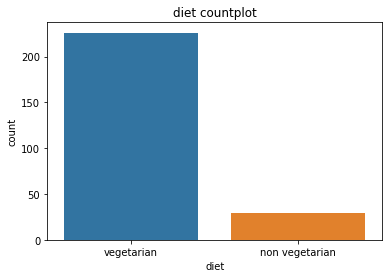

In [9]:
g_diet = sns.countplot(data=df, x="diet", order = df['diet'].value_counts().index)
g_diet.set_title("diet countplot")

Most of them seem to be vegitarian.

Let's see on view of rate. I'll count them.

In [10]:
df_diet =  df[["diet"]].copy()
df_diet["count"] = 1
df_diet = df_diet.groupby("diet").count()
df_diet.head()

count
diet                 
non vegetarian     29
vegetarian        226

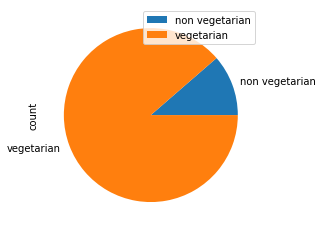

In [11]:
df_diet.plot.pie(y="count")

Looking at the pie chart, the ratios were more intuitive. We can see that it's almost 90% vegetarian.

### flavor_profile

flavor_profile represents dish flaver. Let's see them.

Text(0.5, 1.0, 'flavor_profile countplot')

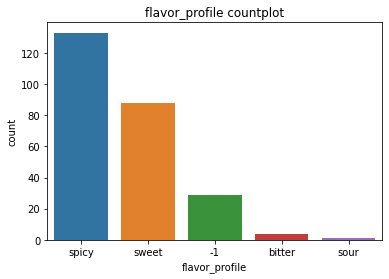

In [12]:
g_flavor_profile = sns.countplot(data=df, x="flavor_profile", order = df['flavor_profile'].value_counts().index)
g_flavor_profile.set_title("flavor_profile countplot")

-1 in any of the columns indicates NaN value.

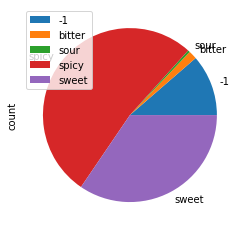

In [13]:
df_flavor_profile =  df[["flavor_profile"]].copy()
df_flavor_profile["count"] = 1
df_flavor_profile = df_flavor_profile.groupby("flavor_profile").count()
df_flavor_profile.plot.pie(y="count")

The most common flavor is spicy. The next most common is sweet. We can see that these two make up roughly 80% or more of the total.

### course

Cource represents dish's type in cource.

Text(0.5, 1.0, 'course countplot')

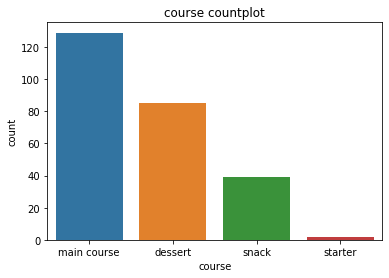

In [14]:
g_course = sns.countplot(data=df, x="course", order = df['course'].value_counts().index)
g_course.set_title("course countplot")

The most common is main cource. The next most common is dessert. The third is snack. Also, there is a little starter.

### region

region represents witch region's dish. The characteristics of the dishes should be influenced by cooperation in the region.

Text(0.5, 1.0, 'region countplot')

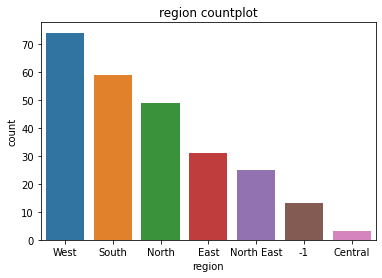

In [15]:
g_region = sns.countplot(data=df, x="region", order = df['region'].value_counts().index)
g_region.set_title("region countplot")

Text(0.5, 1.0, 'region countplot')

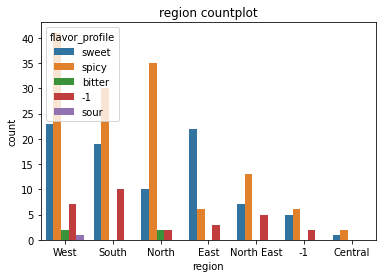

In [16]:
g_region = sns.countplot(data=df, x="region", hue="flavor_profile", order = df['region'].value_counts().index)
g_region.set_title("region countplot")

Let's visualize the flavor_profile for each region to try it out. It's almost the same, but most of the regions have a lot of spicy profiles, while East has a lot of sweet profiles. Also, sour is concentrated in West.

### state

region represents which state's dish.

Text(0.5, 1.0, 'state countplot')

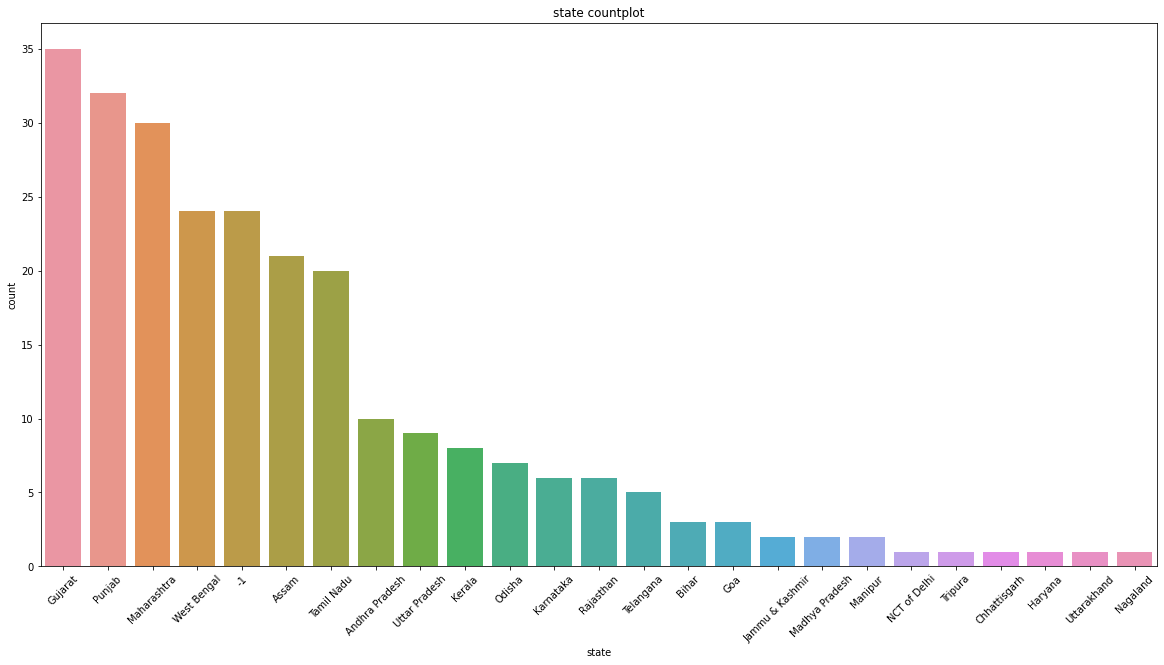

In [17]:
plt.figure(figsize=(20, 10))
g_state = sns.countplot(data=df, x="state",order = df['state'].value_counts().index)
g_state.set_xticklabels(g_state.get_xticklabels(), rotation=45)
g_state.set_title("state countplot")

The states seem to be somewhat scattered, but they tend to be concentrated in the first six or so states. Also there is quite a lot of null.

### prep_time and cook_time

These columns represent preperation and cooking time.

/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'prep_time countplot')

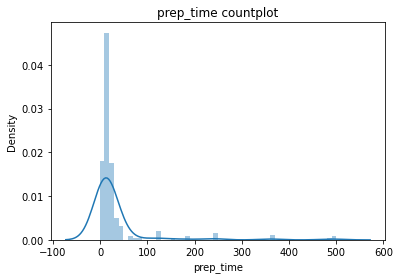

In [18]:
g_prep_time = sns.distplot(df["prep_time"])
g_prep_time.set_title("prep_time countplot")

/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'cook_time countplot')

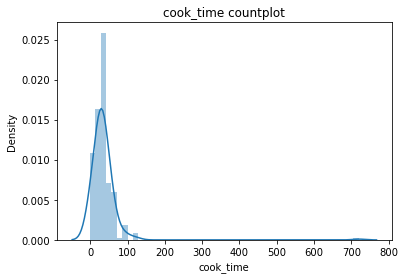

In [19]:
g_cook_time = sns.distplot(df["cook_time"])
g_cook_time.set_title("cook_time countplot")

Most of the foods seem to be completed preparing and cooking in less than 100 minutes.

But, there are very elaborate dish... I would love to try such painstakingly prepared food.

### ingredients

ingredients represents what the food is made of. This is sentence, so I'll parse them to words and count frequency.

In [20]:
all_words = []
for i in range(len(df)):
    txt =  df["ingredients"][i]
    #txt =  txt.replace(', ', ',').lower()
    #all_words += [ word for word in re.split('[,.]',txt) ]
    all_words += [word.lower() for word in nltk.word_tokenize(txt) if not word in ['.', ',']]
    
word_freq = collections.Counter(all_words)
W = WordCloud().fit_words(word_freq)

And let's turn it into a word cloud.

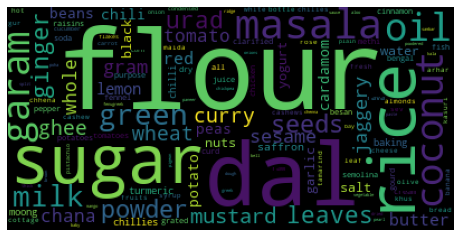

In [21]:
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(W)
plt.axis('off')
plt.show()

Flour, dal and sugar are noticeable in cloud. 

# <div class="alert alert-block alert-info">Analysis of similarity</div>

Now, I focus on word included in ingredients. This is because if we use same ingredient, the results should be naturally similar.

First, we got all ingredient words. They are following.

In [22]:
words = np.array(list(word_freq.keys()))
words

array(['maida', 'flour', 'yogurt', 'oil', 'sugar', 'gram', 'ghee',
       'carrots', 'milk', 'cashews', 'raisins', 'kewra', 'clarified',
       'butter', 'almonds', 'pistachio', 'saffron', 'green', 'cardamom',
       'powder', 'plain', 'baking', 'water', 'rose', 'syrup', 'lentil',
       'corn', 'soda', 'vinegar', 'curd', 'turmeric', 'cottage', 'cheese',
       'rice', 'dried', 'fruits', 'nuts', 'refined', 'besan', 'powdered',
       'yoghurt', 'firm', 'white', 'pumpkin', 'kitchen', 'lime', 'alum',
       'condensed', 'spices', 'semolina', 'khoa', 'coconut', 'molu',
       'leaf', 'dry', 'chhena', 'chenna', 'cream', 'lemon', 'juice',
       'flakes', 'fried', 'power', 'fennel', 'seeds', 'jaggery', 'wheat',
       'sweetened', 'reduced', 'vegetable', 'elachi', 'and', 'peanuts',
       'dharwadi', 'buffalo', 'loaf', 'bread', 'salt', 'black', 'lentils',
       'mung', 'bean', 'skimmed', 'chickpeas', 'chana', 'dal', 'apricots',
       'vermicelli', 'pudding', 'banana', 'khus-khus', 'cucumb

From all words and ingredients of each food, I create "ingredients vector". This vector represents which ingredients the food has. Length of this vector is lenght of list of all ingredient words. If food includes "red pepper" as ingredient, the element of the vector corresponding to "red pepper" is 1. If not, it's zero.

In [23]:
def gen_ingredients_vector(ingredients):
    ingredients_vec = np.zeros(words.shape)
    ingredients = set([word.lower() for word in nltk.word_tokenize(ingredients) if not word in ['.', ',']])
    for ingredient in ingredients:
        idx = np.where(words == ingredient)
        ingredients_vec[idx] = 1
    return ingredients_vec.tolist()

df["ingredients_vec"] = df["ingredients"].map(gen_ingredients_vector)

df.head()

name                                        ingredients  \
0      Balu shahi                    Maida flour, yogurt, oil, sugar   
1          Boondi                            Gram flour, ghee, sugar   
2  Gajar ka halwa       Carrots, milk, sugar, ghee, cashews, raisins   
3          Ghevar  Flour, ghee, kewra, milk, clarified butter, su...   
4     Gulab jamun  Milk powder, plain flour, baking powder, ghee,...   

         diet  prep_time  cook_time flavor_profile   course        state  \
0  vegetarian         45         25          sweet  dessert  West Bengal   
1  vegetarian         80         30          sweet  dessert    Rajasthan   
2  vegetarian         15         60          sweet  dessert       Punjab   
3  vegetarian         15         30          sweet  dessert    Rajasthan   
4  vegetarian         15         40          sweet  dessert  West Bengal   

  region                                    ingredients_vec  
0   East  [1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...  
1   West  [0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, ...  
2  North  [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, ...  
3   West  [0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, ...  
4   East  [0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, ...

## Cosine similarity

I use cosine similarity to calculate similarity of ingredients vectors. Cosine similarity often used to calculate sentence similarity. In fact, ingredients vectors represent sentence, so it should be a good match. If cosine similarity between two foods is high, we can say the foods are similar. 

![cosine similarity](https://wikimedia.org/api/rest_v1/media/math/render/svg/1d94e5903f7936d3c131e040ef2c51b473dd071d)

For more detail of cosine similarity, please refer following:

https://en.wikipedia.org/wiki/Cosine_similarity

In [24]:
# To input heatmap, I made ingredients_vecs.
ingredients_vecs = []
for i in range(len(df)):
    ingredients_vecs.append(df["ingredients_vec"][i])
    
ingredients_vecs = np.array(ingredients_vecs)

In [25]:
ingredients_vecs

array([[1., 1., 1., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 1., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [26]:
cos_matrix = cosine_similarity(ingredients_vecs, ingredients_vecs)

Text(0.5, 1.0, 'cosine_similarity of ingredients_vectors')

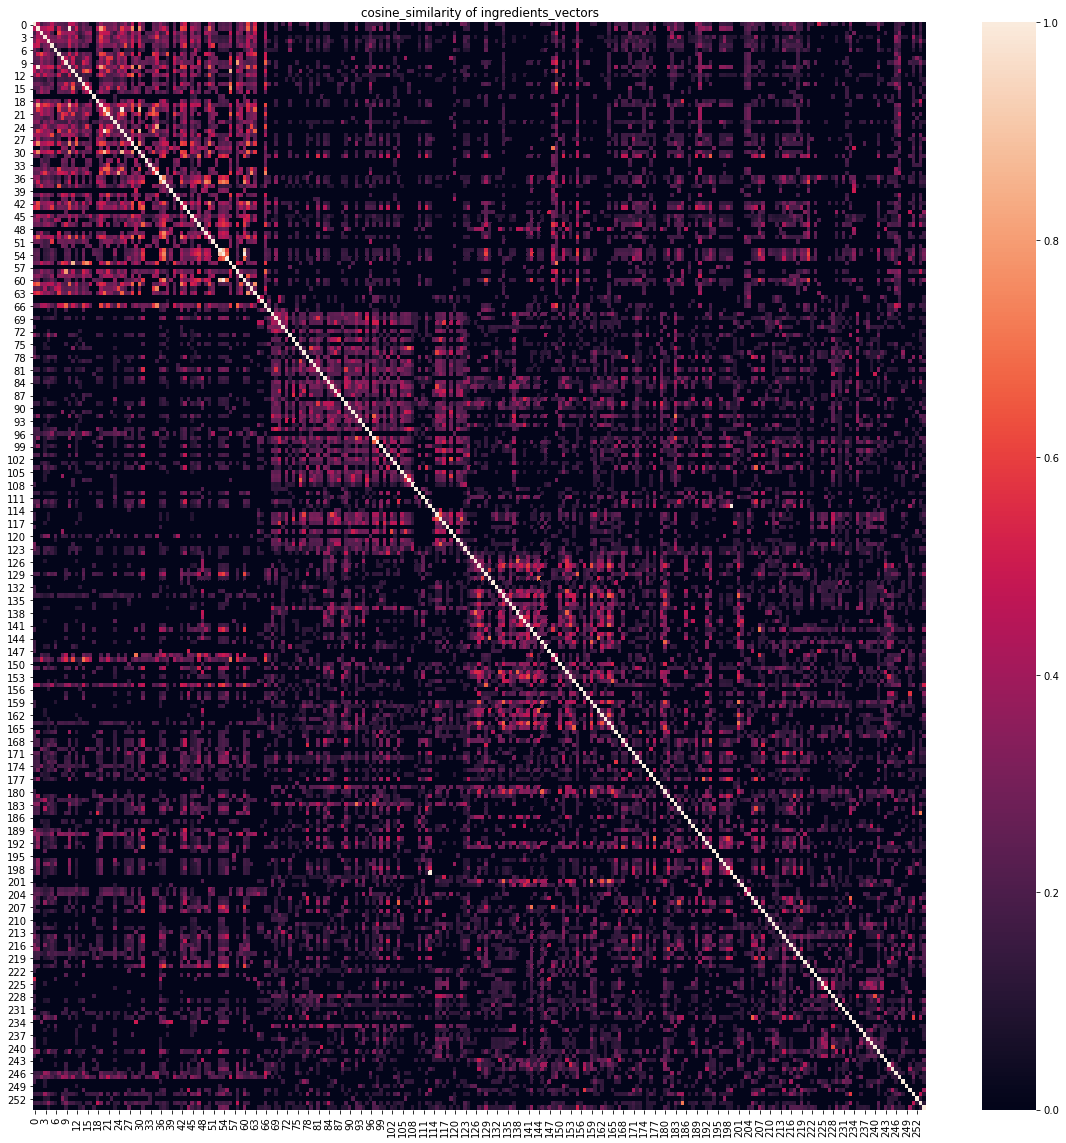

In [27]:
plt.figure(figsize=(20, 20))
ax = sns.heatmap(cos_matrix)
ax.set_title("cosine_similarity of ingredients_vectors")

We can't understand the details because plot is so detailed 😅, but we can see that there are about 5 blocks of high cosine similarity near the diagonal elements.



For example, 0 - 66th (as you can see, this numbers correspond to index of "df")  ingredients vectors have high cosine similarity each others. 

Think in the same way, we reckon 66th - 108th, 109th - 159th, 160th - 222th and 223th - 255th as blocks. (Note that there is no statistical basis for this, it's just an rough estimate.)

Let's find out exactly how similar they really are!

### Following two sweets are similar. Their cosine similarity is high.

In [28]:
df.iloc[[10,12]]

name                                        ingredients        diet  \
10      Laddu                            Gram flour, ghee, sugar  vegetarian   
12  Nankhatai  Refined flour, besan, ghee, powdered sugar, yo...  vegetarian   

    prep_time  cook_time flavor_profile   course state region  \
10         10         40          sweet  dessert    -1     -1   
12         20         30          sweet  dessert    -1     -1   

                                      ingredients_vec  
10  [0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, ...  
12  [0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, ...

In [29]:
cosine_similarity([ingredients_vecs[10]], [ingredients_vecs[12]])

array([[0.5]])

Laddu is a sphere-shaped sweet originating from the Indian subcontinent. Nankhatai are shortbread biscuits, originating from the Indian subcontinent, popular in Northern India and Pakistan. This two sweets are similar.

- Laddu

![Laddu](https://upload.wikimedia.org/wikipedia/commons/thumb/d/d9/Laddu-Janakpur-Community_Outreach-City_Tour_Day-4-6751.jpg/220px-Laddu-Janakpur-Community_Outreach-City_Tour_Day-4-6751.jpg)

- Nankhatai

![Nankhatai](https://upload.wikimedia.org/wikipedia/commons/thumb/3/37/Nankhatai.jpg/220px-Nankhatai.jpg)

(Explanations and pictures are from https://en.wikipedia.org/wiki/)

### Following two sweets are not similar. Their cosine similarity is low.

In [30]:
df.iloc[[10,56]]

name              ingredients        diet  prep_time  cook_time  \
10    Laddu  Gram flour, ghee, sugar  vegetarian         10         40   
56  Basundi        Sugar, milk, nuts  vegetarian         10         35   

   flavor_profile   course    state region  \
10          sweet  dessert       -1     -1   
56          sweet  dessert  Gujarat   West   

                                      ingredients_vec  
10  [0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, ...  
56  [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, ...

In [31]:
cosine_similarity([ingredients_vecs[10]], [ingredients_vecs[56]])

array([[0.28867513]])

Basundi is an Indian sweet in Gujarat, Maharashtra , Telangana, Tamil Nadu and Karnataka. By following pictures, you can found it's certainly not similar.

- Laddu

![Laddu](https://upload.wikimedia.org/wikipedia/commons/thumb/d/d9/Laddu-Janakpur-Community_Outreach-City_Tour_Day-4-6751.jpg/220px-Laddu-Janakpur-Community_Outreach-City_Tour_Day-4-6751.jpg)

- Basundi

![Basundi](https://upload.wikimedia.org/wikipedia/commons/thumb/3/39/Basundi_Indian_Dessert_Mithai_Sweets.jpg/220px-Basundi_Indian_Dessert_Mithai_Sweets.jpg)

(Explanations and pictures are from https://en.wikipedia.org/wiki/)

## Demonstrating the validity of the vectors by kmeans and umap.

I also try to demonstrate the validity of ingredients vector by kmeans and umap.

By cosine similarity heatmap, we found that there are five gruops, so I'll define the groups by kmeans. (Of cource, these cluster doesn't necessarily match the five group, though.)

And using umap, I'll confirm that we can separete ingredients vector to the clusters in low dimension.

In [32]:
kmeans = KMeans(n_clusters=5, random_state=0).fit(ingredients_vecs)

In [33]:
reducer = umap.UMAP()
embedding = reducer.fit_transform(ingredients_vecs)

Text(0.5, 1.0, 'UMAP projection of ingredients vectors')

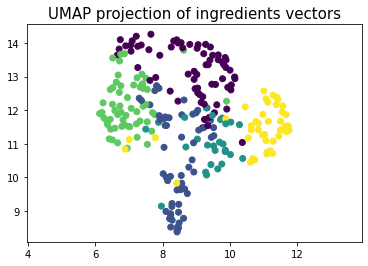

In [34]:
plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=kmeans.labels_)
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of ingredients vectors', fontsize=15)

As you can see, some of it is mixed, but you can see that the foods are coming together relatively nicely. So we may say that ingredients vector represents simmilarity of foods nicely.

## Similarity search:

To find out similar dishes region-wise or state-wise based on list of ingredients, I made get_cosine_similarity_heatmap function. You can generate heatmap filtered by region and state. If you can see high similar cells on heatmap, you can search high similar dishes.

Let's search!

In [35]:
def get_cosine_similarity_heatmap(df,state=None, region=None):
    """
    Visualize cosine similarity heatmap of ingredients vector.
    And return filtered dataframe.
    """
    
    if state==None and region==None:
        df_filtered = df
    elif state!=None:
        df_filtered = df[df["state"]==state]
    elif region!=None:
        df_filtered = df[df["region"]==region]
    else:
        df_filtered = df[df["state"]==state & df["region"]==region]
    
    #ingredients_vecs = []
    
    ingredients_vecs = [vec for vec in df_filtered["ingredients_vec"]]
    #for i in range(len(df_filtered)):
    #    ingredients_vecs.append(df_filtered["ingredients_vec"][i])
    
    ingredients_vecs = np.array(ingredients_vecs)
    cos_matrix = cosine_similarity(ingredients_vecs, ingredients_vecs)
    
    plt.figure(figsize=(15, 15))
    ax = sns.heatmap(cos_matrix)
    ax.set_title(f"cosine_similarity of ingredients_vectors in {state} and {region}")
    
    return df_filtered.reset_index()

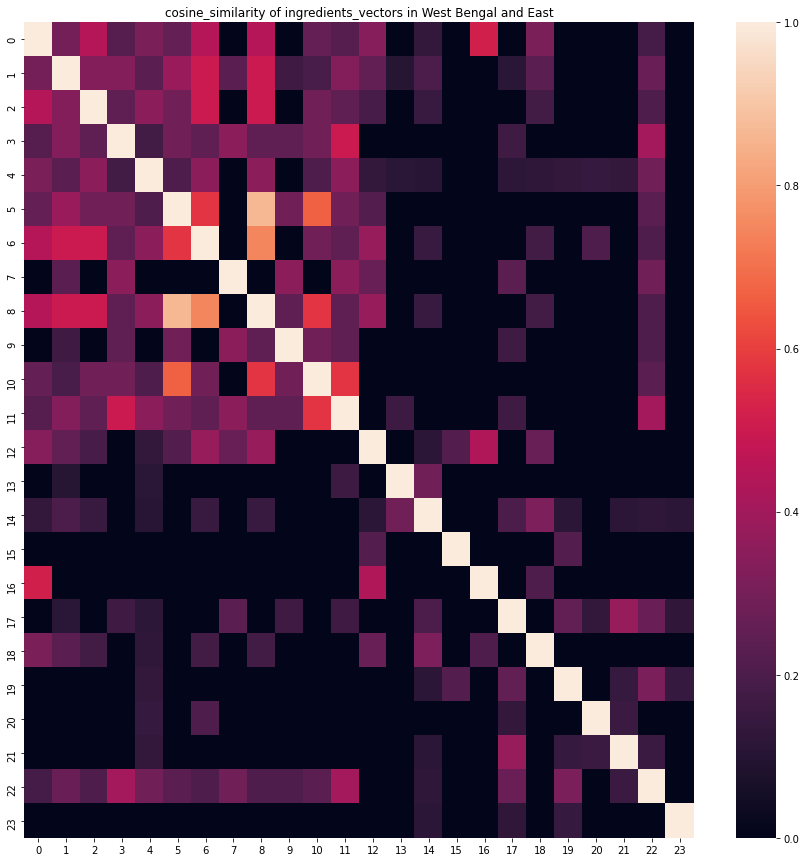

In [36]:
df_WestBengal_East = get_cosine_similarity_heatmap(df, "West Bengal", "East")

As you can see heatmap, index 5 and 8 are similar.

Let's check their ingredients.



In [37]:
df_WestBengal_East.iloc[[5,8]]

index      name                 ingredients        diet  prep_time  \
5     25  Ledikeni         Chhena, sugar, ghee  vegetarian         45   
8     30    Pantua  Chhena, sugar, ghee, flour  vegetarian         45   

   cook_time flavor_profile   course        state region  \
5         45          sweet  dessert  West Bengal   East   
8         45          sweet  dessert  West Bengal   East   

                                     ingredients_vec  
5  [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, ...  
8  [0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, ...

Index 5 is Ledikeni and index 9 is Pantua. Luckily, wikipedia clearly states that the two dishes are similar.

> Pantua is very similar to the cheese-based fried sweet ledikeni.

![Pantua](https://upload.wikimedia.org/wikipedia/commons/thumb/0/0b/Pantua_-_Kolkata_2011-09-20_5431.JPG/220px-Pantua_-_Kolkata_2011-09-20_5431.JPG)

Pitcure and explanation are from https://en.wikipedia.org/wiki/Pantua

## <div class="alert alert-block alert-success">Concludion</div>

I made word vector called  ingredients vector from dish's ingredients.

With cosine similarity, I can find similar dishes region-wise or state-wise.